#### Tuning with Optuna
###### Packages

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Metric and model form scikit-learn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
# Boosting model
import catboost as cb
# import lightgbm as lgb
import xgboost as xgb
# Tuning optimization
import optuna
import optuna.visualization as vis
# System utilities
import warnings
warnings.filterwarnings("ignore")
import sys
print(sys.executable)


/usr/local/bin/python3


#### The Dataset

In [2]:
df = pd.read_csv(r"Test/Churn_clean.csv") # Data cleaning and feature engineering done in Feature_Engineering.ipynb
df.head()

,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Flag_Contatto_Call_Center,Flag_variazione_Accredito_Stipendio,Num_Punti_Programma_Loyalty,Imp_Liquidit�_Attuale,Imp_Gestito_attuale,Imp_Amministrato_attuale,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID
0,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,3.0,...,1.0,0.0,NaN,1634.57,2978.40,2980.92,0,0,0,0
1,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,4.0,...,1.0,-1.0,325.0,11918.26,NaN,34916.15,0,0,0,0
2,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,4.0,...,1.0,0.0,460.0,2671.95,NaN,232776.62,1,0,0,0
3,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,2.0,...,0.0,-1.0,NaN,19211.31,15013.53,15017.53,0,0,0,0
4,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,NaN,...,1.0,NaN,3650.0,1526.38,NaN,NaN,0,0,0,0


In [3]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  
XX = pd.get_dummies(X)


In [4]:
def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df
# After creating dummies, the model was not able to elaborate certain columns due to the presence of special characters

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # Split 4:5, random state to ensure reproducibility
# To ensure that the size is the same even after the split
XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False)) 
X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]
# apply clean_feature_names
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

X_train, X_test = X_train.align(X_test, join='inner', axis=1)

X_train_final = X_train
X_test_final = X_test
y_train_final = y_train
y_test_final = y_test

#### The Syntetic Dataset
###### To elaborate the algorithms on the syntetic dataset, first there is the elaboration of the feature engineering on the syntetic dataset too.

In [6]:
synthetic_df = pd.read_csv(r"Competition/Datasets/Synthetic_dataset.csv")
synthetic_df = synthetic_df.drop('Id_Cliente',axis=1)

In [7]:
synthetic_df=synthetic_df
synthetic_df['Professione'] = synthetic_df['Professione'].apply(lambda x: 'Ufficiale/Sottoufficiale' if x == 'Ufficiale/Sottufficiale' else 
                                                                  'Libero professionista/Titolare impresa' if x == 'Libero professionista/Titolare di impresa' else 
                                                                  x)
synthetic_df['Provincia_Residenza'] = synthetic_df['Provincia_Residenza'].replace('FO', 'FC')
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('FO', 'FC')

synthetic_df['Provincia_Residenza'] = synthetic_df['Provincia_Residenza'].replace('PS', 'PU')
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('PS', 'PU')

synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('8N', np.nan)
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('BE', np.nan)
mapping = {
    'CAUTO': 1,
    'PRUDENTE': 2,
    'BILANCIATO': 3,
    'DINAMICO':4,
    'ND':0
}
synthetic_df['Profilo_MIFID'] = synthetic_df['Profilo_MIFID'].replace(mapping)

mapping2 = {
    'Bassissimo (<1200)': 1,
    'Basso (tra 1200 e 1500)': 2,
    'Medio (tra 1500 e 1800)': 3,
    'Alto (tra 1800 e 2500)':4,
    'Altissimo (>2500)':5
}

synthetic_df['Imp_Reddito'] = synthetic_df['Imp_Reddito'].replace(mapping2)
#log transformation done during feature engineering
synthetic_df['log_Imp_Bonifici_vs_Competitors'] = np.log10(synthetic_df['Imp_Bonifici_vs_Competitors'])
synthetic_df['log_Imp_Bonifici_vs_No_Competitors'] = np.log10(synthetic_df['Imp_Bonifici_vs_No_Competitors'])
synthetic_df['log_Imp_Gestito_attuale'] = np.log10(synthetic_df['Imp_Gestito_attuale'])
synthetic_df['log_Num_Punti_Programma_Loyalty'] = np.log10(synthetic_df['Num_Punti_Programma_Loyalty'])
synthetic_df = synthetic_df.drop(['Imp_Bonifici_vs_Competitors', 'Imp_Bonifici_vs_No_Competitors', 'Imp_Gestito_attuale', 'Num_Punti_Programma_Loyalty', 'Imp_Gestito_attuale_6m', 'Imp_Liquidit�_Attuale_6m', 'Imp_Amministrato_attuale_6m'], axis =1)

In [8]:
X_synthetic = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y_synthetic = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  

In [9]:
# Same process as before to ensure that column lenght is the same since once we train our model with specific columns, we need to ensure that our model has in input a df with same lenght and names
X_synthetic = pd.get_dummies(X_synthetic)
X_train_synthetic = clean_feature_names(X_synthetic)

missing_columns_train = set(XX.columns) - set(X_train_synthetic.columns)
for col in missing_columns_train:
    X_train_synthetic[col] = 0  

X_train_res_synthetic = X_train_synthetic[XX.columns]

print("Training features:", X_train_res_synthetic.shape)


Training features: (70000, 276)


#### Boosting alghoritms and Hyperparameters tuning

##### First alghorithm: LightGBM

In [18]:
def objective(trial): # A trial is a process of evaluating an objective function
    #
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1]) # Rateo between minority and majority class to deal with the unbalance nature of the dataset
# Now we set the parameters for the tuning: the range is wide and the reason will be explained soon
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'scale_pos_weight': scale_pos_weight, 
        'force_col_wise': True,
        'verbosity': -1
    }
# We use CV to ensure that our model is able to generalize, and it's not just luck with a lucky split
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # the number of split is equal to 10 to ensure that each row of the df has been once in the test set and 9 times in the train
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index] # #y_fold_val is 30190

        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1]  # We predict the probability
        top_indices = np.argsort(probas)[-1698:]  # Sort the probability is descending order and select top 5000 (1:6 of the total more or less)
     # Now we count the number of positive contained in our choosen list out of the total as metric  
        top_positives = y_fold_val.iloc[top_indices].sum() 
        total_positives = y_fold_val.sum()  
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  

    return np.mean(scores) # Mean for every split
# Optuna provide us the TPE Sampler: it's a Bayesian hyperparameter optimization algorithms that is able to learn about the relationship between the hyperparameters and the objective function to choose the parameters for each tria
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50) 

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)

history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()


[I 2024-05-08 12:15:57,068] A new study created in memory with name: no-name-5abef84b-4e23-411d-bd4b-ab4aeb0715d4
[I 2024-05-08 12:16:27,553] Trial 0 finished with value: 0.33333333333333337 and parameters: {'n_estimators': 175, 'learning_rate': 0.1540359659501924, 'max_depth': 13, 'num_leaves': 32, 'min_child_samples': 16, 'subsample': 0.8311989040672406, 'subsample_freq': 0, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.6011150117432088, 'reg_lambda': 0.7080725777960455, 'max_bin': 202}. Best is trial 0 with value: 0.33333333333333337.
[I 2024-05-08 12:17:12,002] Trial 1 finished with value: 0.4320754716981132 and parameters: {'n_estimators': 294, 'learning_rate': 0.0823143373099555, 'max_depth': 7, 'num_leaves': 23, 'min_child_samples': 17, 'subsample': 0.8608484485919076, 'subsample_freq': 4, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 0.2912291401980419, 'reg_lambda': 0.6118528947223795, 'max_bin': 214}. Best is trial 1 with value: 0.4320754716981132.
[I 2024-05-

Best Hyperparameters: {'n_estimators': 218, 'learning_rate': 0.01924315730262365, 'max_depth': 14, 'num_leaves': 39, 'min_child_samples': 25, 'subsample': 0.9614156550100574, 'subsample_freq': 3, 'colsample_bytree': 0.7963352256675209, 'reg_alpha': 0.3944497642389667, 'reg_lambda': 0.5504332251782049, 'max_bin': 245}
Best Score for Top 50,000: 0.5748427672955975


In [19]:
# We stopped the tuning earlier since we found a good set of parameters and tuning wasn't giving us better results but was converging to the same parameters
'''
[I 2024-04-23 17:36:46,835] Trial 26 finished with value: 0.8232704402515724 and parameters: {'n_estimators': 297, 'learning_rate': 0.010065762501114987, 'max_depth': 13, 'num_leaves': 25, 'min_child_samples': 28, 'subsample': 0.9186047768818155, 'subsample_freq': 5, 'colsample_bytree': 0.8969786318428297, 'reg_alpha': 0.9097824682690728, 'reg_lambda': 0.6075396766185748, 'max_bin': 289}. Best is trial 26 with value: 0.8232704402515724.
'''
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

best_params = {
    "n_estimators": 297,
    "learning_rate": 0.010065762501114987,
    "max_depth": 13,
    "num_leaves": 25,
    "min_child_samples": 28,
    "subsample": 0.9186047768818155,
    "subsample_freq": 5,
    "colsample_bytree": 0.8969786318428297,
    "reg_alpha": 0.9097824682690728,
    "reg_lambda": 0.6075396766185748,
    "max_bin": 289,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train_final, y_train_final)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test_final)[:, 1]

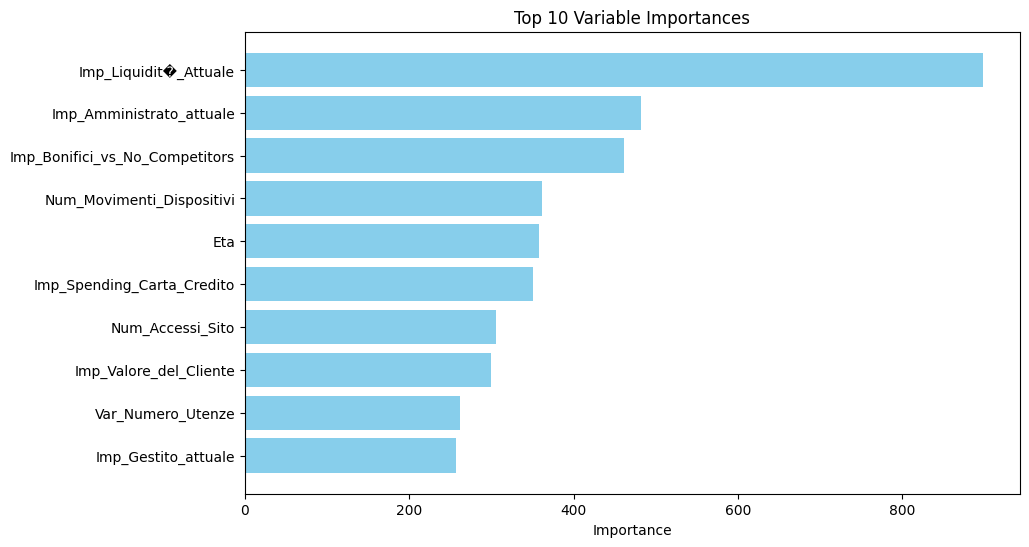

In [20]:
# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train_final.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  
plt.show()

###### We want to see how our final model perform on test set, selecting the top 10k clients with higher probability to be in the minority class

In [21]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': lgbm_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
17678        1      0.929932
236314       0      0.924741
58354        1      0.922639
25853        1      0.919385
257262       0      0.915076
...        ...           ...
331734       0      0.548037
318528       0      0.548006
29252        0      0.547986
328239       0      0.547967
172432       0      0.547925

[10000 rows x 2 columns]


In [22]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 312
Numero di 'SI: nel nostro test set 393


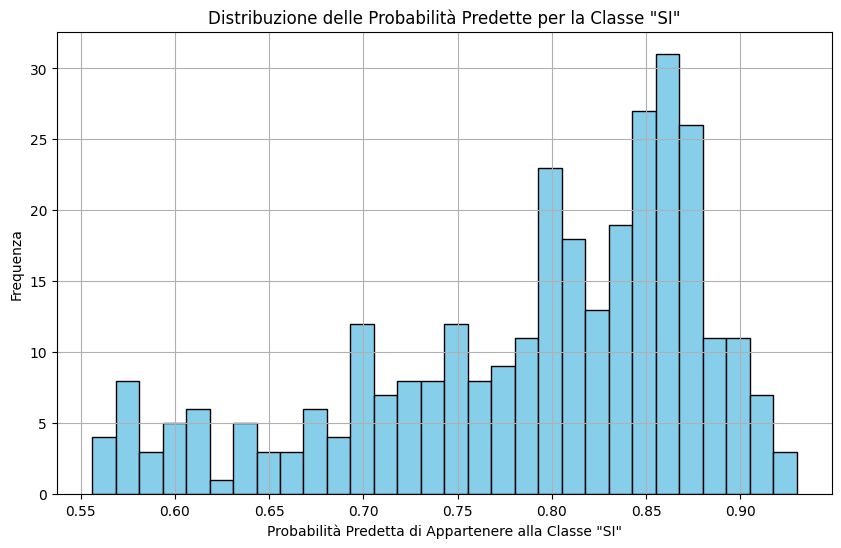

In [23]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

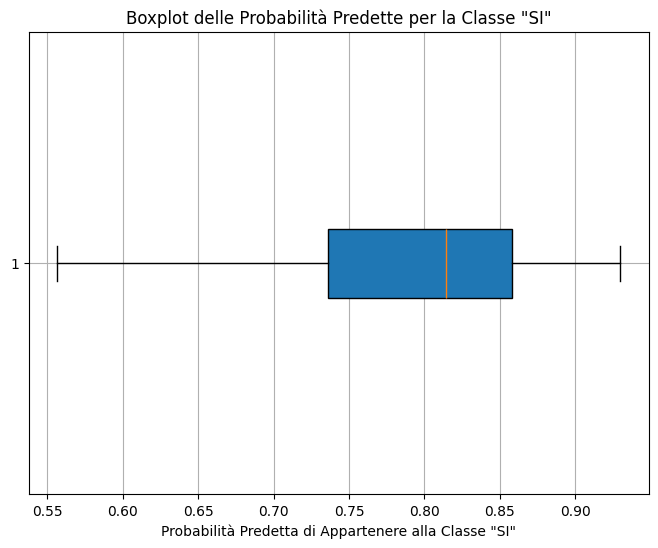

In [24]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

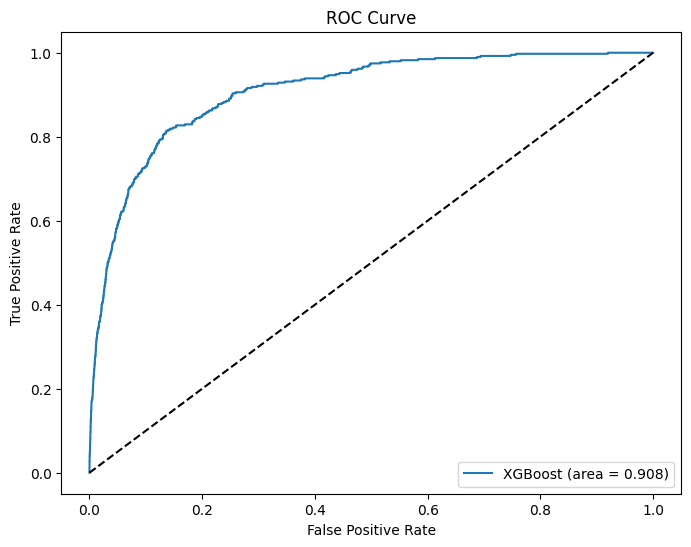

In [25]:
fpr, tpr, thresholds = roc_curve(y_test_final, lgbm_predictions)
auc = roc_auc_score(y_test_final, lgbm_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

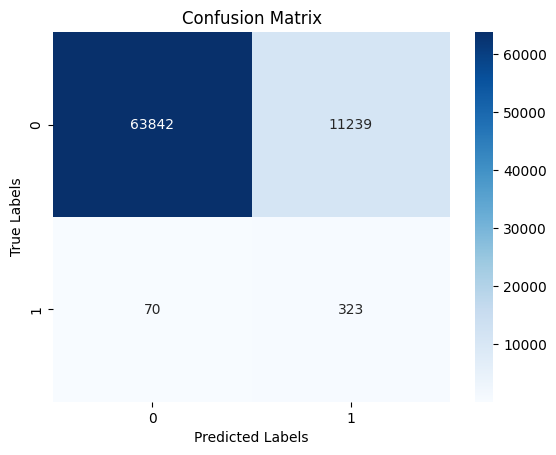

In [26]:
y_pred = best_lgb_classifier.predict(X_test_final)

cm = confusion_matrix(y_test_final, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [27]:
train_sizes, train_scores, test_scores = learning_curve(best_lgb_classifier, X_train, y_train, cv=5, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

KeyboardInterrupt: 

###### The gap between them does not appear to be widening as the training size increases. This suggests that the model is not severely overfitting, as the cross-validation score is improving . The model should be able to generalize on new unseen data, let's see in practice:

##### LightGBM on the syntetic dataset

In [ ]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(10000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
12540       0      0.908441
25811       0      0.907696
40849       0      0.906703
62814       0      0.906341
27956       0      0.905096
...       ...           ...
62870       0      0.469482
18839       0      0.469453
6865        0      0.469448
8420        0      0.469415
37934       0      0.469364

[10000 rows x 2 columns]


In [ ]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 197
Numero di 'SI: nel nostro test set 489


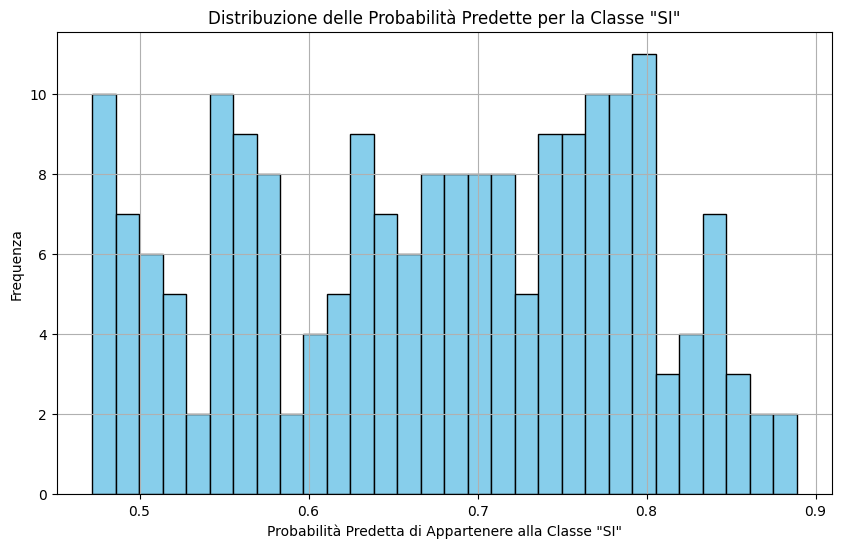

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

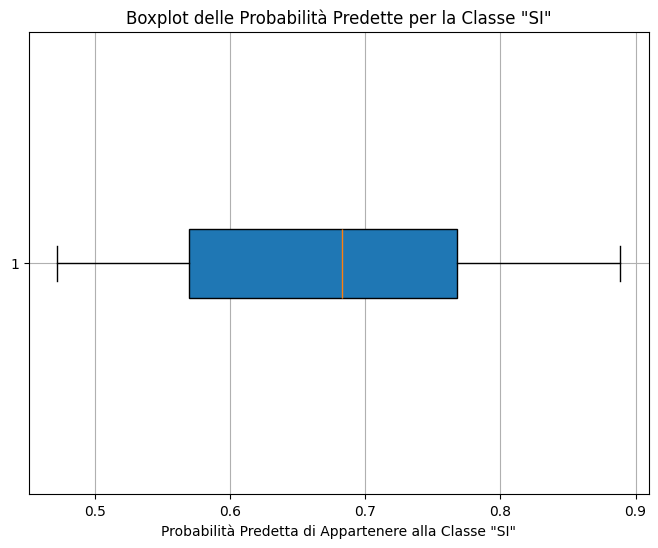

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

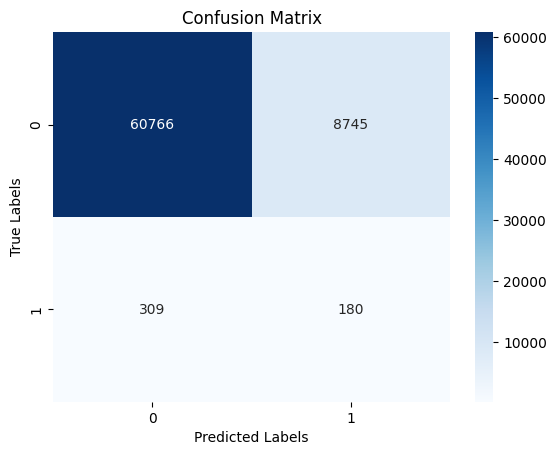

In [ ]:
y_pred = best_lgb_classifier.predict(X_train_res_synthetic)

cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### Second Algorithm: XGBoost

In [10]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
        'scale_pos_weight': scale_pos_weight, 
        'verbosity': 0
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = xgb.XGBClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1] 
        top_indices = np.argsort(probas)[-1698:]  
        top_positives = y_fold_val.iloc[top_indices].sum() 
        total_positives = y_fold_val.sum() 
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)


history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()

[I 2024-05-08 13:43:00,831] A new study created in memory with name: no-name-56caaa5c-a949-492c-a8a7-4dc5dea2625c
[I 2024-05-08 13:49:27,554] Trial 0 finished with value: 0.44654088050314467 and parameters: {'n_estimators': 437, 'learning_rate': 0.4123206532618726, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.2904180608409973, 'reg_alpha': 4.330880728874676, 'reg_lambda': 6.051038616257767}. Best is trial 0 with value: 0.44654088050314467.
[I 2024-05-08 13:59:57,678] Trial 1 finished with value: 0.5333333333333334 and parameters: {'n_estimators': 737, 'learning_rate': 0.01083858126934475, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 0.9170225492671691, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 5.295088673159155}. Best is trial 1 with value: 0.5333333333333334.
[I 2024-05-08 14:05:31,171] Trial 2 finished with value: 0.5484276729

Best Hyperparameters: {'n_estimators': 779, 'learning_rate': 0.05230683198500739, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.6723675387518698, 'colsample_bytree': 0.8481282797708494, 'gamma': 1.0748305640105353, 'reg_alpha': 1.908194383169251, 'reg_lambda': 5.262797824019152}
Best Score for Top 50,000: 0.5874213836477987


###### Application on XGBoost of the best hyperparameters chosen by Optuna

In [38]:
import xgboost
'''
Best Hyperparameters: {'n_estimators': 661, 'learning_rate': 0.036491004518573594, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.6625916610133735, 'colsample_bytree': 0.864803089169032, 'gamma': 3.1877873567760657, 'reg_alpha': 4.436063712881633, 'reg_lambda': 4.7749277591032975}
Best Score for Top 50,000: 0.829559748427673
'''
# There was a problem with the parameters verbosity, I had to set manually a value in range in main xgboost configuration
xgb.set_config(verbosity=0)
config = xgb.get_config()
assert config['verbosity'] == 0
xgboost.config_context(verbosity=0)
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
xgb_params = {
    'n_estimators': 779,
    'learning_rate': 0.05230683198500739,
    'max_depth': 3,
    'min_child_weight': 3,
    'subsample': 0.6723675387518698,
    'colsample_bytree': 0.8481282797708494,
    'gamma': 1.0748305640105353,
    'reg_alpha': 1.908194383169251,
    'reg_lambda': 5.262797824019152,
    'scale_pos_weight': scale_pos_weight,
}

best_xgb_classifier = xgb.XGBClassifier(verbosity=0, **xgb_params)

best_xgb_classifier.fit(X_train_final, y_train_final)
xgb_predictions = best_xgb_classifier.predict_proba(X_test_final)[:, 1]

###### Feature Importance

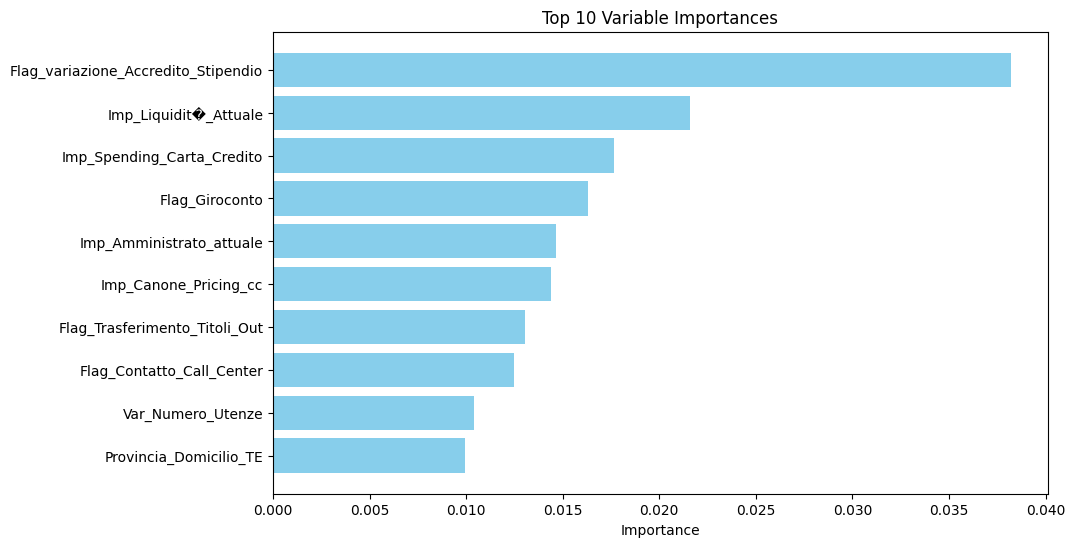

In [39]:
importance = best_xgb_classifier.feature_importances_
features = X_train_final.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis() 
plt.show()


###### Results

In [41]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': xgb_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(4000)
print(top_10000_si)

        y_test  y_pred_proba
17678        1      0.998538
91629        0      0.998410
288850       0      0.998327
76082        0      0.997916
117164       0      0.997646
...        ...           ...
263941       0      0.768268
319540       0      0.768244
67317        0      0.768222
277181       0      0.768209
312635       0      0.768172

[4000 rows x 2 columns]


In [42]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 231
Numero di 'SI: nel nostro test set 393


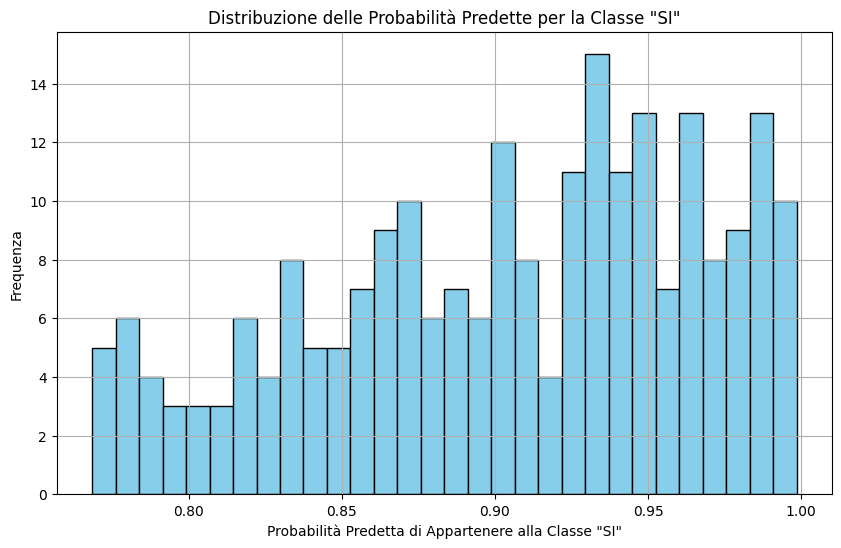

In [43]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

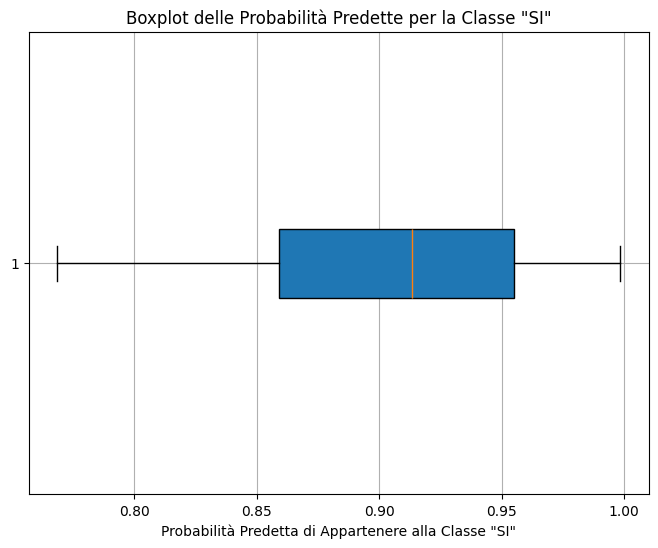

In [44]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

###### It's important to verify if the model is in overfittting. Through the use of the learning curve, we can see in the trained data and the tested data converge: if this happen, the model can summarize good the data, without overfitting. If the two curves remain far, there could be the overfitting risk. The metric used for the comparison is the Recall.

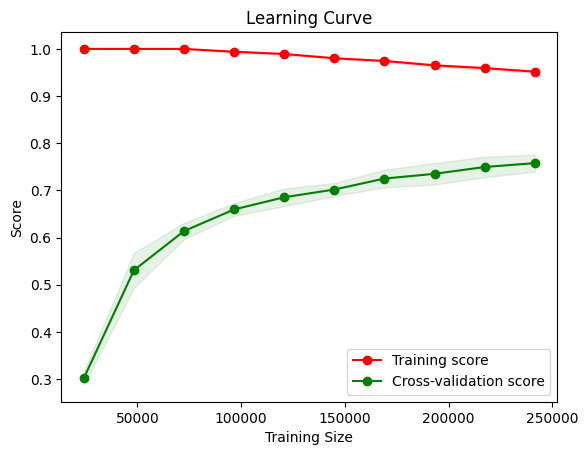

In [17]:
train_sizes, train_scores, test_scores = learning_curve(best_xgb_classifier, X_train_final, y_train_final, cv=5, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

##### XGBoost on the syntetic dataset

In [45]:
X_train_res_synthetic.rename(columns={
    'Professione_Libero professionista/Titolare impresa': 'Professione_Libero_professionista/Titolare_impresa'
}, inplace=True)
#missmatch between column_names

In [46]:
xgb_predictions = best_xgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': xgb_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(4000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
6352        0      0.935260
41056       0      0.932667
44462       0      0.913904
20713       0      0.905331
62547       0      0.898078
...       ...           ...
62665       0      0.352601
67654       0      0.352594
56889       0      0.352581
43319       0      0.352487
40194       0      0.352469

[4000 rows x 2 columns]


In [47]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 47
Numero di 'SI: nel nostro test set 489


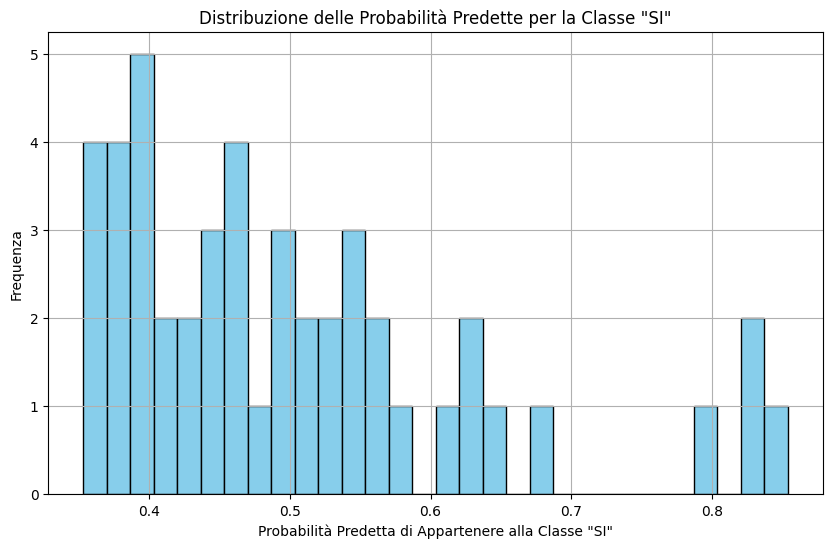

In [48]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

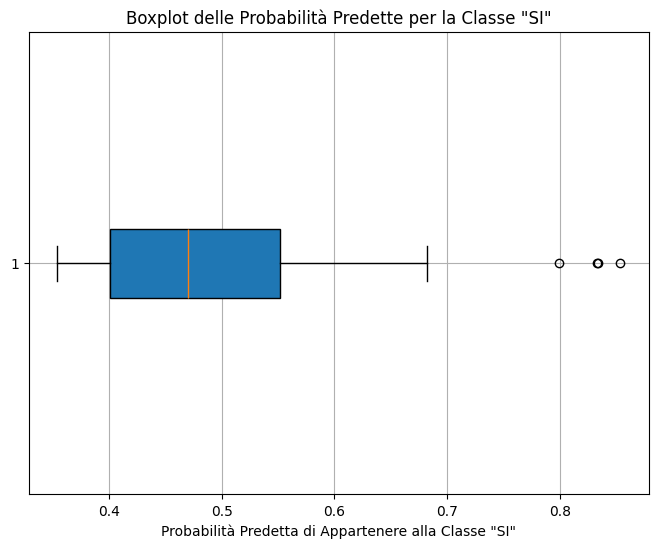

In [49]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

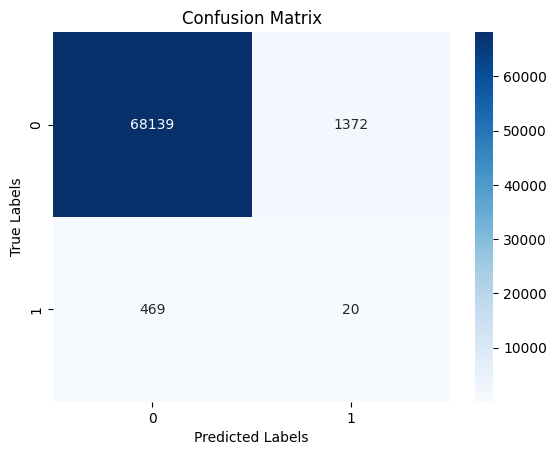

In [50]:
y_pred = best_xgb_classifier.predict(X_train_res_synthetic)

cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Third Alghoritm: Catboost

In [51]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'scale_pos_weight': scale_pos_weight, 
        'verbose': False
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = cb.CatBoostClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1] 
        top_indices = np.argsort(probas)[-1698:]  
        top_positives = y_fold_val.iloc[top_indices].sum() 
        total_positives = y_fold_val.sum() 
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)


history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()

[I 2024-05-08 20:02:11,662] A new study created in memory with name: no-name-9103109e-f0e4-4ae4-a6a1-9c5578608dea


[I 2024-05-08 20:08:16,044] Trial 0 finished with value: 0.5647798742138366 and parameters: {'n_estimators': 250, 'learning_rate': 0.17254716573280354, 'max_depth': 13, 'l2_leaf_reg': 5.986986183486169, 'border_count': 66, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 8, 'leaf_estimation_method': 'Gradient'}. Best is trial 0 with value: 0.5647798742138366.
[I 2024-05-08 20:10:58,664] Trial 1 finished with value: 0.5245283018867924 and parameters: {'n_estimators': 433, 'learning_rate': 0.018891200276189388, 'max_depth': 7, 'l2_leaf_reg': 1.8348616940244846, 'border_count': 100, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 2, 'leaf_estimation_method': 'Gradient'}. Best is trial 0 with value: 0.5647798742138366.
[I 2024-05-08 20:14:36,503] Trial 2 finished with value: 0.5339622641509434 and parameters: {'n_estimators': 282, 'learning_rate': 0.10508421338691762, 'max_depth': 7, 'l2_leaf_reg': 5.142830149697703, 'b

Best Hyperparameters: {'n_estimators': 329, 'learning_rate': 0.05194348975504665, 'max_depth': 14, 'l2_leaf_reg': 7.9578314783147945, 'border_count': 188, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 29, 'leaf_estimation_iterations': 6, 'leaf_estimation_method': 'Gradient'}
Best Score for Top 50,000: 0.5830188679245283


In [52]:
'''
Best Hyperparameters: {'n_estimators': 486, 'learning_rate': 0.08564115269968339, 'max_depth': 5, 'l2_leaf_reg': 5.495063193351241, 'border_count': 113, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 9, 'leaf_estimation_method': 'Gradient'}
Best Score for Top 50,000: 0.8327044025157233
'''
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

catboost_params = {
    'n_estimators': 329,
    'learning_rate': 0.05194348975504665,
    'max_depth': 14,
    'l2_leaf_reg': 7.9578314783147945,
    'border_count': 188,
    'grow_policy': 'Lossguide',
    'min_data_in_leaf': 29,
    'leaf_estimation_iterations': 6,
    'leaf_estimation_method': 'Gradient',
    'scale_pos_weight': scale_pos_weight,
}

best_catboost_classifier = cb.CatBoostClassifier(**catboost_params)

best_catboost_classifier.fit(X_train_final, y_train_final)
catboost_predictions = best_catboost_classifier.predict_proba(X_test_final)[:, 1]


0:	learn: 0.6784285	total: 153ms	remaining: 50.1s
1:	learn: 0.6636979	total: 252ms	remaining: 41.2s
2:	learn: 0.6525466	total: 321ms	remaining: 34.9s
3:	learn: 0.6410748	total: 406ms	remaining: 33s
4:	learn: 0.6287415	total: 511ms	remaining: 33.1s
5:	learn: 0.6192221	total: 595ms	remaining: 32s
6:	learn: 0.6092153	total: 682ms	remaining: 31.4s
7:	learn: 0.5991103	total: 765ms	remaining: 30.7s
8:	learn: 0.5893846	total: 860ms	remaining: 30.6s
9:	learn: 0.5807480	total: 956ms	remaining: 30.5s
10:	learn: 0.5718674	total: 1.06s	remaining: 30.7s
11:	learn: 0.5652888	total: 1.14s	remaining: 30s
12:	learn: 0.5588515	total: 1.32s	remaining: 32.1s
13:	learn: 0.5519783	total: 1.42s	remaining: 31.9s
14:	learn: 0.5455089	total: 1.52s	remaining: 31.7s
15:	learn: 0.5394433	total: 1.63s	remaining: 31.8s
16:	learn: 0.5347766	total: 1.79s	remaining: 32.9s
17:	learn: 0.5291121	total: 1.95s	remaining: 33.7s
18:	learn: 0.5241745	total: 2.06s	remaining: 33.7s
19:	learn: 0.5198731	total: 2.16s	remaining: 33

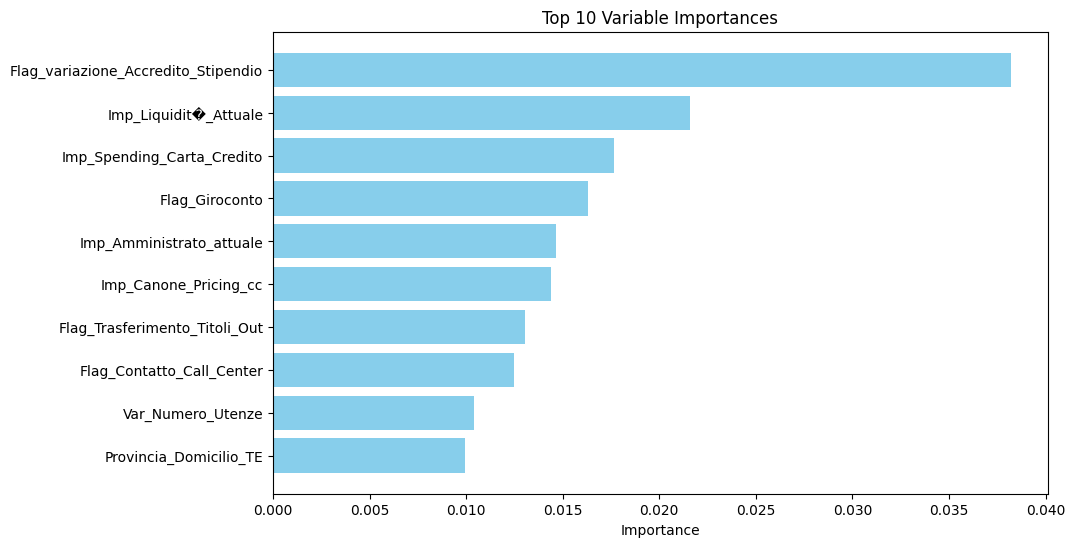

In [53]:
importance = best_xgb_classifier.feature_importances_
features = X_train_final.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


In [54]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': catboost_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(4000)
print(top_10000_si)

        y_test  y_pred_proba
288850       0      0.989451
25853        1      0.985959
91629        0      0.983725
117164       0      0.983199
257262       0      0.981720
...        ...           ...
120786       0      0.760095
261580       0      0.759985
30474        0      0.759963
218521       0      0.759961
257643       0      0.759947

[4000 rows x 2 columns]


In [55]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 236
Numero di 'SI: nel nostro test set 393


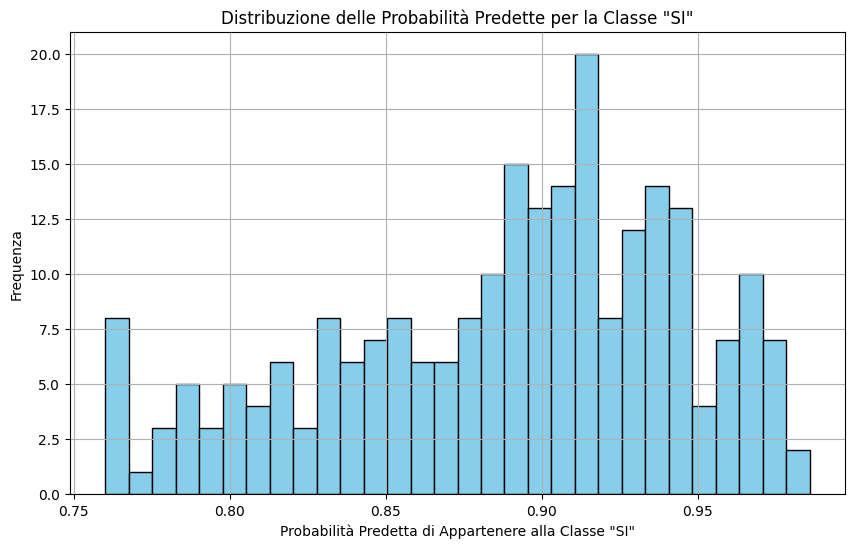

In [56]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

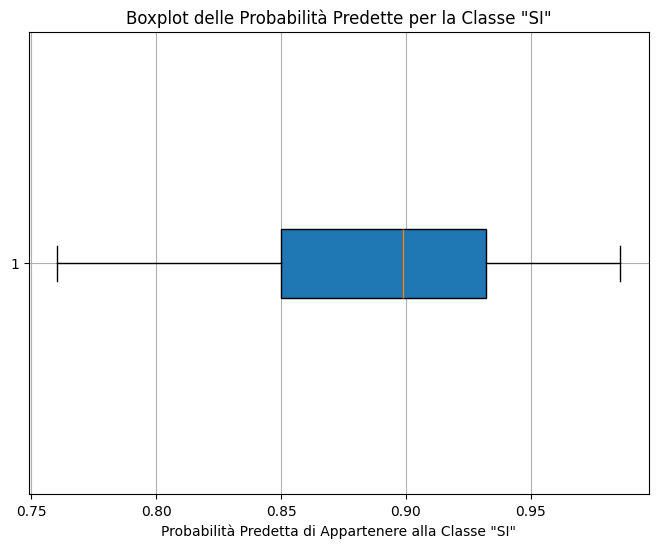

In [57]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

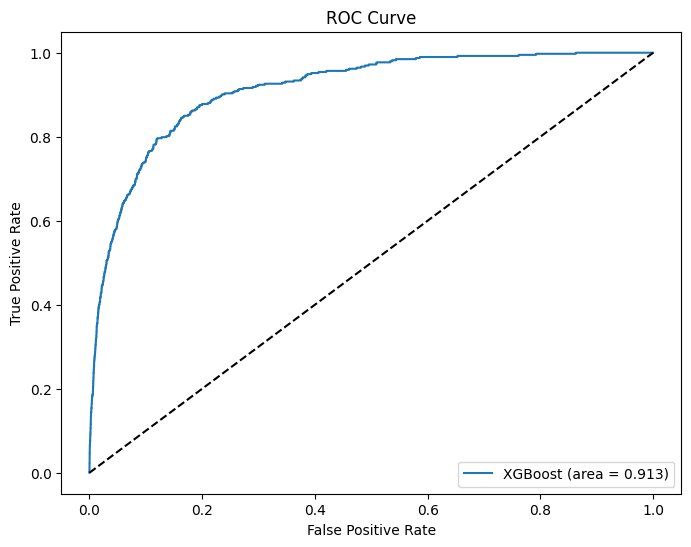

In [58]:
fpr, tpr, thresholds = roc_curve(y_test_final, catboost_predictions)
auc = roc_auc_score(y_test_final, catboost_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

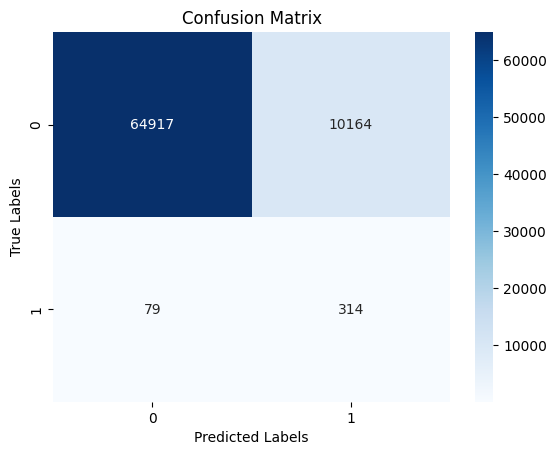

In [59]:
y_pred = best_catboost_classifier.predict(X_test_final)

cm = confusion_matrix(y_test_final, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


0:	learn: 0.6781302	total: 288ms	remaining: 1m 34s
1:	learn: 0.6664707	total: 344ms	remaining: 56.3s
0:	learn: 0.6773277	total: 817ms	remaining: 4m 27s
2:	learn: 0.6526556	total: 1.03s	remaining: 1m 52s
3:	learn: 0.6422168	total: 1.38s	remaining: 1m 52s
1:	learn: 0.6638852	total: 1.39s	remaining: 3m 46s
0:	learn: 0.6761658	total: 788ms	remaining: 4m 18s
4:	learn: 0.6299851	total: 1.73s	remaining: 1m 52s
5:	learn: 0.6160098	total: 2.12s	remaining: 1m 54s
2:	learn: 0.6522975	total: 2.06s	remaining: 3m 44s
6:	learn: 0.6041134	total: 2.4s	remaining: 1m 50s
0:	learn: 0.6788235	total: 1.12s	remaining: 6m 8s
1:	learn: 0.6628268	total: 1.72s	remaining: 4m 41s
3:	learn: 0.6401410	total: 2.41s	remaining: 3m 15s
0:	learn: 0.6815881	total: 903ms	remaining: 4m 56s
7:	learn: 0.5929983	total: 2.65s	remaining: 1m 46s
8:	learn: 0.5864851	total: 3s	remaining: 1m 46s
4:	learn: 0.6301343	total: 2.81s	remaining: 3m 2s
1:	learn: 0.6647495	total: 1.68s	remaining: 4m 34s
2:	learn: 0.6498625	total: 2.17s	remai

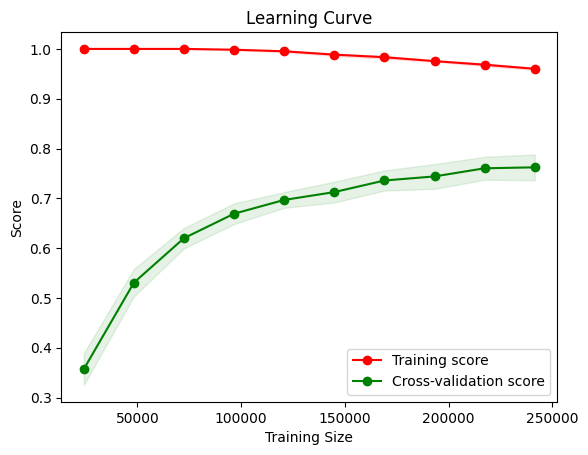

In [60]:
train_sizes, train_scores, test_scores = learning_curve(best_catboost_classifier, X_train_final, y_train_final, cv=5, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

##### Catboost on the syntethic dataset

In [62]:
catboost_predictions = best_catboost_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': catboost_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(4000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
25443       0      0.958150
54195       0      0.943701
39581       0      0.940799
36604       0      0.939349
54899       0      0.939216
...       ...           ...
29441       0      0.657223
7461        0      0.657214
68925       0      0.657146
50742       0      0.657136
26633       0      0.657132

[4000 rows x 2 columns]


In [63]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 113
Numero di 'SI: nel nostro test set 489


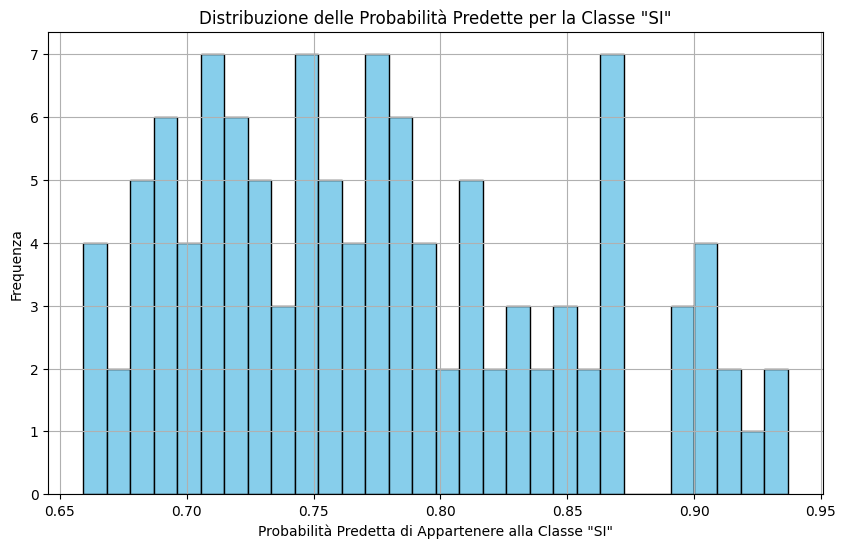

In [64]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

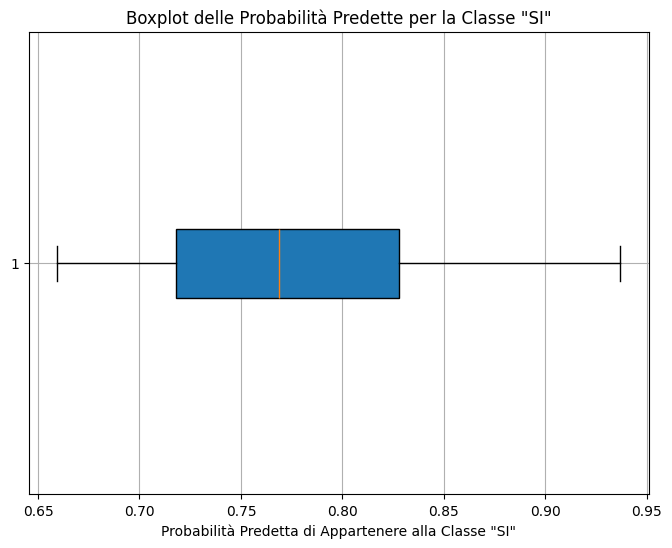

In [65]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

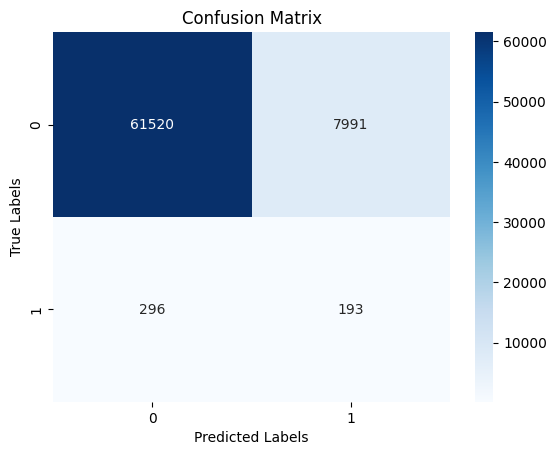

In [66]:
y_pred = best_catboost_classifier.predict(X_train_synthetic)

cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Forth Method: 'Merging' of the previous three methods with a respective weight

In [ ]:
def objective(trial):
    # Assuming X and y are your features and labels respectively
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    weight_catboost = trial.suggest_float('weight_catboost', 0, 1)
    weight_xgb = trial.suggest_float('weight_xgb', 0, 1 - weight_catboost)

    # Calculate weight for LightGBM as the remainder
    weight_lgbm = 1 - weight_catboost - weight_xgb

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        catboost_predictions = best_catboost_classifier.predict_proba(X_fold_val)[:, 1]
        xgb_predictions = best_xgb_classifier.predict_proba(X_fold_val)[:, 1]
        lgbm_predictions = best_lgb_classifier.predict_proba(X_fold_val)[:, 1]
        ensemble_predictions = (weight_catboost * catboost_predictions) + (weight_xgb * xgb_predictions) + (weight_lgbm * lgbm_predictions)

        top_indices = np.argsort(ensemble_predictions)[-5000:]  
        top_positives = y_fold_val.iloc[top_indices].sum() 
        total_positives = y_fold_val.sum() 
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)


history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()

[I 2024-04-24 23:42:10,368] A new study created in memory with name: no-name-b18c7748-b9d1-4afd-a2be-6c6accfde669
[I 2024-04-24 23:42:22,669] Trial 0 finished with value: 0.9509433962264152 and parameters: {'weight_catboost': 0.3745401188473625, 'weight_xgb': 0.5946336570972584}. Best is trial 0 with value: 0.9509433962264152.
[I 2024-04-24 23:42:35,079] Trial 1 finished with value: 0.9672955974842766 and parameters: {'weight_catboost': 0.7319939418114051, 'weight_xgb': 0.16044410055080702}. Best is trial 1 with value: 0.9672955974842766.
[I 2024-04-24 23:42:47,074] Trial 2 finished with value: 0.960377358490566 and parameters: {'weight_catboost': 0.15601864044243652, 'weight_xgb': 0.1316564673568783}. Best is trial 1 with value: 0.9672955974842766.
[I 2024-04-24 23:43:02,900] Trial 3 finished with value: 0.9446540880503143 and parameters: {'weight_catboost': 0.05808361216819946, 'weight_xgb': 0.815865506454398}. Best is trial 1 with value: 0.9672955974842766.
[I 2024-04-24 23:43:19,50

Best Hyperparameters: {'weight_catboost': 0.8401280016423606, 'weight_xgb': 0.014810444862548743}
Best Score for Top 50,000: 0.9723270440251571


In [ ]:
# Manually set the weight
weight_catboost = 0.84
weight_xgb = 0.02
weight_lgbm = 0.16

In [ ]:
catboost_predictions = best_catboost_classifier.predict_proba(X_test_final)[:, 1]
xgb_predictions = best_xgb_classifier.predict_proba(X_test_final)[:, 1]
lgbm_predictions = best_lgb_classifier.predict_proba(X_test_final)[:, 1]

ensemble_predictions = (weight_catboost * catboost_predictions) + (weight_xgb * xgb_predictions) + (weight_lgbm * lgbm_predictions)

In [ ]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': ensemble_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
17678        1      1.006673
25853        1      1.004493
58243        1      1.003854
168555       0      1.003671
257262       0      1.003332
...        ...           ...
142752       0      0.504835
369583       0      0.504636
20769        0      0.504634
330206       0      0.504601
181832       0      0.504592

[10000 rows x 2 columns]


In [ ]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 315
Numero di 'SI: nel nostro test set 393


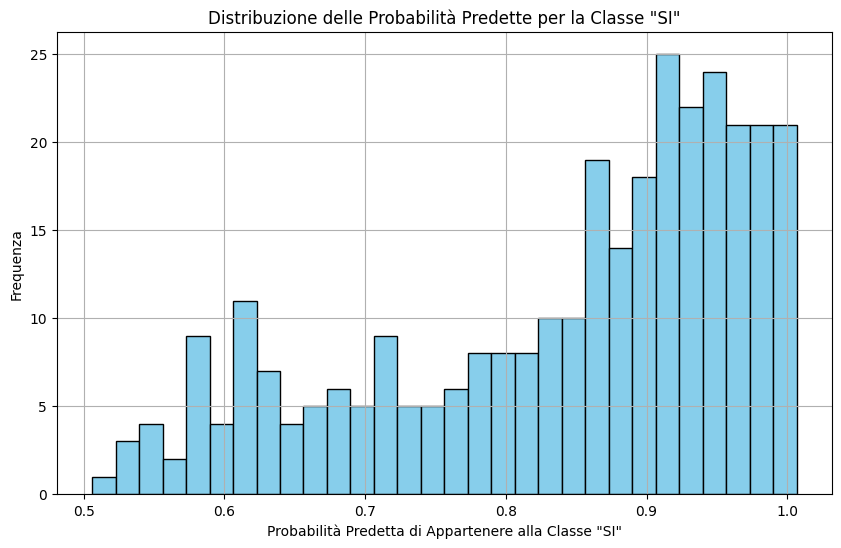

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

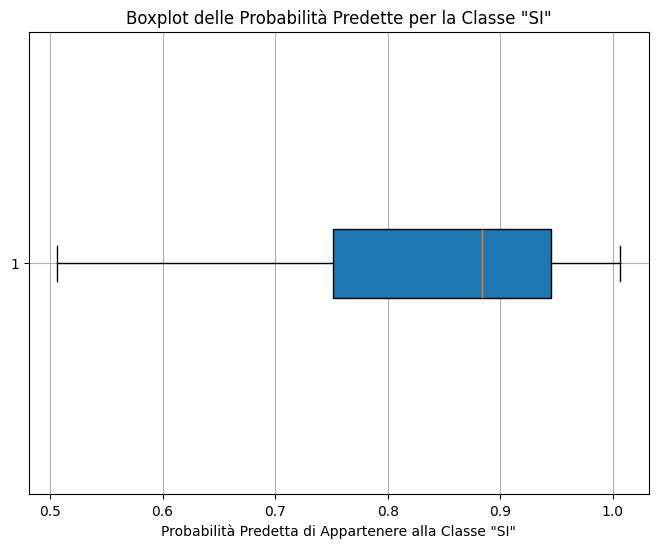

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

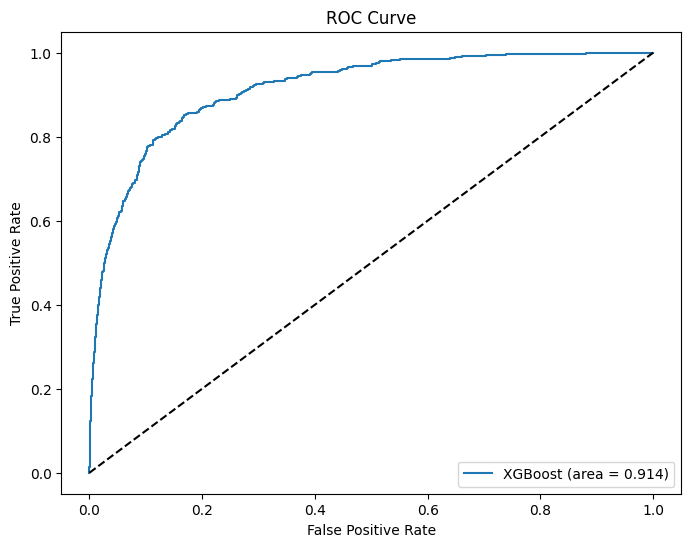

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, ensemble_predictions)
auc = roc_auc_score(y_test, ensemble_predictions)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

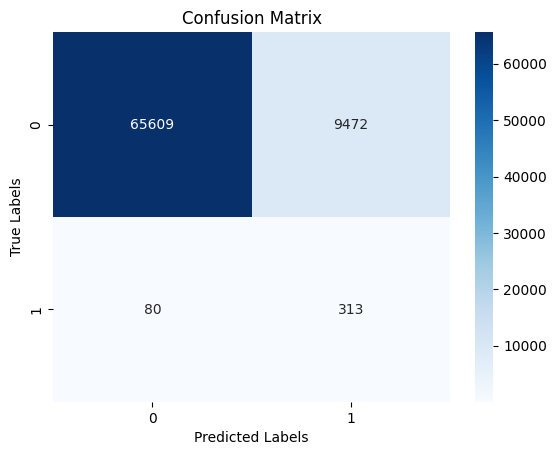

In [ ]:
catboost_pred = best_catboost_classifier.predict(X_test_final)
xgb_pred = best_xgb_classifier.predict(X_test_final)
lgbm_pred = best_lgb_classifier.predict(X_test_final)

y_pred = (weight_catboost * catboost_pred) + (weight_xgb * xgb_pred) + (weight_lgbm * lgbm_pred)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

cm = confusion_matrix(y_test_final, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### Merged alghorithms on the Synthetic dataset

In [ ]:
xgb_predictions_synt = best_xgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
lgbm_predictions_synt = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
catboost_predictions_synt = best_catboost_classifier.predict_proba(X_train_res_synthetic)[:, 1]
ensemble_predictions_synth = (weight_catboost * catboost_predictions_synt) + (weight_xgb* xgb_predictions_synt) + (weight_lgbm * lgbm_predictions_synt)
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': ensemble_predictions_synth

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(10000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
32924       0      0.986354
64438       0      0.985757
33720       0      0.985512
27956       0      0.981765
38912       0      0.978512
...       ...           ...
66241       0      0.446905
69143       0      0.446755
64559       0      0.446742
33958       0      0.446741
16894       0      0.446728

[10000 rows x 2 columns]


In [ ]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 205
Numero di 'SI: nel nostro test set 489


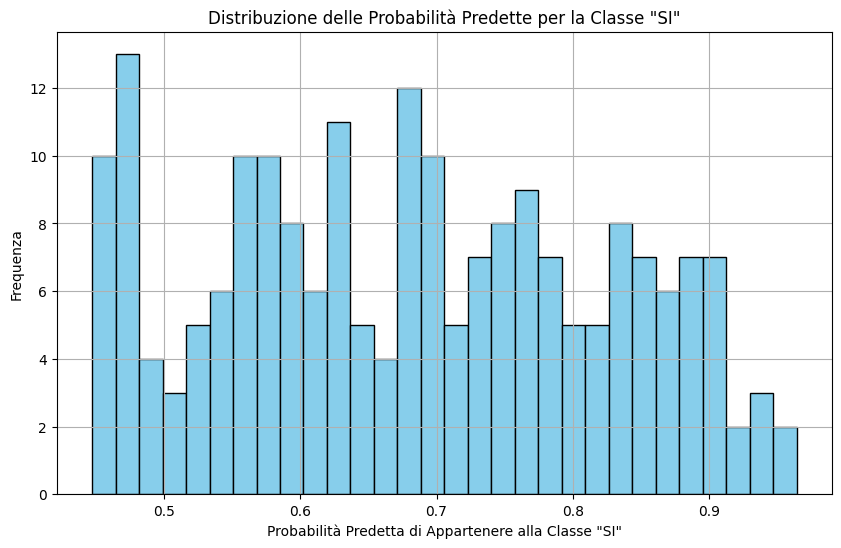

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

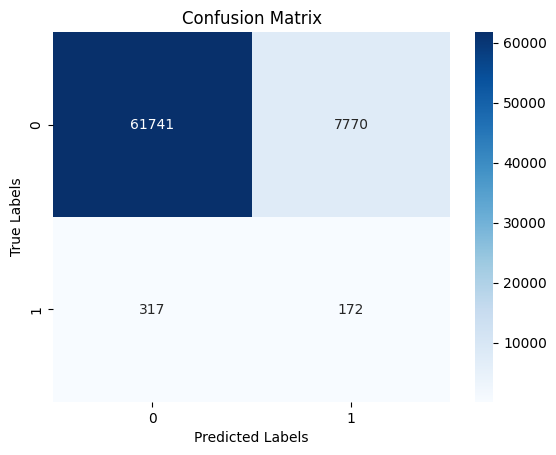

In [ ]:
xgb_predictions_synt = best_xgb_classifier.predict(X_train_res_synthetic)
lgbm_predictions_synt = best_lgb_classifier.predict(X_train_res_synthetic)
catboost_predictions_synt = best_catboost_classifier.predict(X_train_res_synthetic)
ensemble_predictions_synth = (weight_catboost * catboost_predictions_synt) + (weight_xgb* xgb_predictions_synt) + (weight_lgbm * lgbm_predictions_synt)

y_pred_binary = np.where(ensemble_predictions_synth > 0.5, 1, 0)

cm = confusion_matrix(y_synthetic, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()